In [1]:
from Bio import SeqIO
import pandas as pd
from Bio.Seq import Seq
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
path_real = "/home/chensa/gb_data/data_for_analysis/"
codons_table = {
        'TTT': 'F', 'CTT': 'L', 'ATT': 'I', 'GTT': 'V',
        'TTC': 'F', 'CTC': 'L', 'ATC': 'I', 'GTC': 'V',
        'TTA': 'L', 'CTA': 'L', 'ATA': 'I', 'GTA': 'V',
        'TTG': 'L', 'CTG': 'L', 'ATG': 'M', 'GTG': 'V',
        'TCT': 'S', 'CCT': 'P', 'ACT': 'T', 'GCT': 'A',
        'TCC': 'S', 'CCC': 'P', 'ACC': 'T', 'GCC': 'A',
        'TCA': 'S', 'CCA': 'P', 'ACA': 'T', 'GCA': 'A',
        'TCG': 'S', 'CCG': 'P', 'ACG': 'T', 'GCG': 'A',
        'TAT': 'Y', 'CAT': 'H', 'AAT': 'N', 'GAT': 'D',
        'TAC': 'Y', 'CAC': 'H', 'AAC': 'N', 'GAC': 'D',
        'TAA': '*', 'CAA': 'Q', 'AAA': 'K', 'GAA': 'E',
        'TAG': '*', 'CAG': 'Q', 'AAG': 'K', 'GAG': 'E',
        'TGT': 'C', 'CGT': 'R', 'AGT': 'S', 'GGT': 'G',
        'TGC': 'C', 'CGC': 'R', 'AGC': 'S', 'GGC': 'G',
        'TGA': '*', 'CGA': 'R', 'AGA': 'R', 'GGA': 'G',
        'TGG': 'W', 'CGG': 'R', 'AGG': 'R', 'GGG': 'G'
    }
stops = set(["TAA","TAG","TGA"])
!pwd

/home/chensa


## Edit distance

In [2]:
kozak1 = "GCCACCATGG"
kozak2 = "GCCGCCATGG"
def get_dist(koz):
    dist = 0
    for a,b,c in zip(koz,kozak1,kozak2):
        if a != b and a != c:
            dist += 1
    return dist

In [3]:
mrna_distances = []
records = SeqIO.parse(f"{path_real}mRNA_5utr_d1.fasta", "fasta")
for rec in records:
    koz = str(rec.seq[-10:])
    mrna_distances.append(get_dist(koz))
ribo_distances = []
records = SeqIO.parse(f"{path_real}ribo_5utr_d1.fasta", "fasta")
for rec in records:
    koz = str(rec.seq[-10:])
    ribo_distances.append(get_dist(koz))
ncrna_distances = []
records = SeqIO.parse(f"{path_real}ncRNA_5utr_d1.fasta", "fasta")
for rec in records:
    koz = str(rec.seq[-10:])
    ncrna_distances.append(get_dist(koz))

from collections import Counter
mrna_counts = dict(Counter(mrna_distances))
mrna_counts = {k: v/sum(mrna_counts.values()) for k,v in mrna_counts.items()}
ribo_counts = dict(Counter(ribo_distances))
ribo_counts = {k: v/sum(ribo_counts.values()) for k,v in ribo_counts.items()}
ncrna_counts = dict(Counter(ncrna_distances))
ncrna_counts = {k: v/sum(ncrna_counts.values()) for k,v in ncrna_counts.items()}

all_distances = sorted(set(mrna_counts) | set(ribo_counts) | set(ncrna_counts))

mrna_values = [mrna_counts.get(d, 0) for d in all_distances]
ribo_values = [ribo_counts.get(d, 0) for d in all_distances]
ncrna_values = [ncrna_counts.get(d, 0) for d in all_distances]



In [4]:
len(ribo_distances),len(mrna_distances),len(ncrna_distances)

(6296, 18891, 6296)

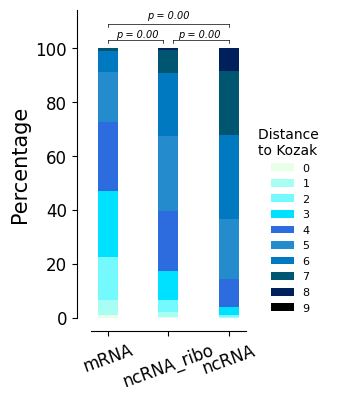

In [5]:
data = {
    'mRNA': [mrna_counts.get(d, 0) for d in all_distances],
    'Ribo': [ribo_counts.get(d, 0) for d in all_distances],
    'ncRNA': [ncrna_counts.get(d, 0) for d in all_distances]
}
x = [1, 1.06, 1.12]

fig, ax = plt.subplots(figsize=(2, 4))
colors = ["#e8ffe8", "#a6fff2", "#74f9ff", "#00e0ff", "#2d6cdf","#248bcc", "#0079c1","#005670", "#00205b", "#000000"]
# Plot the stacked bar chart

for i in range(0,len(mrna_values)):
    ax.bar(x[0], mrna_values[i], width=0.02, bottom=sum(mrna_values[:i]), color=colors[i], label=f'{i}')
    ax.bar(x[1], ribo_values[i], width=0.02, bottom=sum(ribo_values[:i]), color=colors[i])
    ax.bar(x[2], ncrna_values[i], width=0.02, bottom=sum(ncrna_values[:i]), color=colors[i])


plt.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0,fontsize=8, title='Distance \nto Kozak', title_fontsize=10,frameon=False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.set_xticks([1,1.06,1.12])
ax.set_xticklabels(['mRNA', 'ncRNA_ribo', 'ncRNA'], rotation=20, fontsize=12)

# ax.set_ylim(0, 1.08)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_yticklabels([f'{int(i*100)}' for i in np.arange(0, 1.1, 0.2)], fontsize=12)
ax.set_ylabel('Percentage', fontsize=15)

ax.plot([x[0], x[1]-0.005], [1.03,1.03], color='black', lw=0.5)
ax.plot([x[0], x[0]], [1.02,1.03], color='black', lw=0.5)
ax.plot([x[1]-0.005, x[1]-0.005], [1.02,1.03], color='black', lw=0.5)

ax.plot([x[1]+0.005, x[2]], [1.03,1.03], color='black', lw=0.5)
ax.plot([x[1]+0.005, x[1]+0.005], [1.02,1.03], color='black', lw=0.5)
ax.plot([x[2], x[2]], [1.02,1.03], color='black', lw=0.5)

ax.plot([x[0], x[2]], [1.09,1.09], color='black', lw=0.5)
ax.plot([x[0], x[0]], [1.08,1.09], color='black', lw=0.5)
ax.plot([x[2],x[2]], [1.08,1.09], color='black', lw=0.5)

plt.annotate(f'p = 0.00', xy=(0.3, 0.91), xycoords='axes fraction',
             ha='center', fontsize=7, style='italic')
plt.annotate(f'p = 0.00', xy=(0.7, 0.91), xycoords='axes fraction',
             ha='center', fontsize=7, style='italic')
plt.annotate(f'p = 0.00', xy=(0.5, 0.97), xycoords='axes fraction',
             ha='center', fontsize=7, style='italic')


plt.savefig(f"{path_real}figures/"+"kozak_distance.pdf", format='pdf', bbox_inches='tight')

In [13]:
for k,v in data.items():
    print(k, np.sum(v[:4]),np.sum(v[-4:]),np.sum(v[4:6]))

mRNA 0.47048859245143193 0.08697263247048859 0.4425387750780795
Ribo 0.17233163913595934 0.32623888182973315 0.5014294790343075
ncRNA 0.04050190597204574 0.6353240152477764 0.3241740787801779


In [6]:
from scipy.stats import mannwhitneyu

mannwhitneyu(mrna_distances, ribo_distances), mannwhitneyu(mrna_distances, ncrna_distances), mannwhitneyu(ribo_distances, ncrna_distances)

(MannwhitneyuResult(statistic=33165546.5, pvalue=0.0),
 MannwhitneyuResult(statistic=14964993.0, pvalue=0.0),
 MannwhitneyuResult(statistic=11530345.0, pvalue=0.0))

## energy

In [8]:
os.chdir('/home/chensa/gb_data/data_for_analysis/energy')

import re

pattern = r'\(\s*(-?\d+\.\d+)\s*\)'

ribo_egy = []
with open("res_ribo_d50", "r") as file:
    data = file.read()
ribo_egy = re.findall(pattern, data)
ribo_egy = [float(i) for i in ribo_egy]

ncRNA_egy = []
with open("res_ncRNA_d50", "r") as file:
    data = file.read()
ncRNA_egy = re.findall(pattern, data)
ncRNA_egy = [float(i) for i in ncRNA_egy]

mRNA_egy = []
with open("res_mRNA_d50", "r") as file:
    data = file.read()
mRNA_egy = re.findall(pattern, data)
mRNA_egy = [float(i) for i in mRNA_egy]
print(len(ribo_egy), len(ncRNA_egy), len(mRNA_egy))

6296 6296 18891


In [13]:
# mRNA_egy = np.array(mRNA_egy); ribo_egy = np.array(ribo_egy); ncRNA_egy = np.array(ncRNA_egy)
# np.quantile(mRNA_egy,0.75),(np.sum(ribo_egy <= -8.1) / len(ribo_egy)), (np.sum(ncRNA_egy <= -8.1) / len(ncRNA_egy))

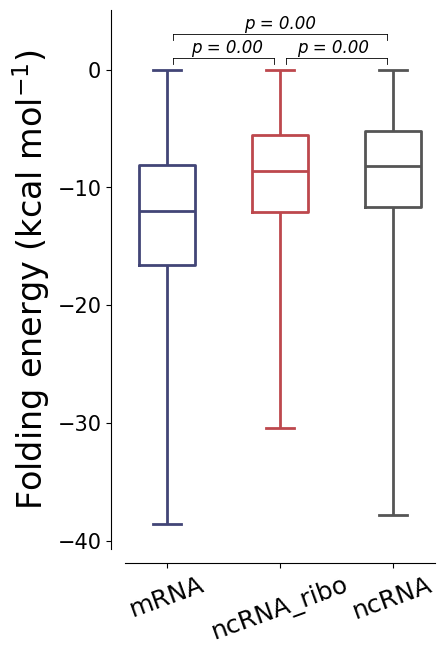

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

data = pd.DataFrame({'group': ['mRNA'] * len(mRNA_egy) + ['ncRNA_ribo'] * len(ribo_egy) + ['ncRNA'] * len(ncRNA_egy),
                     'energy': mRNA_egy + ribo_egy + ncRNA_egy})

plt.figure(figsize=(4, 7))

sns.boxplot(data=data[data['group'] == 'mRNA'], x='group', y='energy', 
            color='#424577', width=0.5, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)
sns.boxplot(data=data[data['group'] == 'ncRNA_ribo'], x='group', y='energy', 
            color='#bd484d', width=0.5, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)

sns.boxplot(data=data[data['group'] == 'ncRNA'], x='group', y='energy', fill=False,
            color='#555555', width=0.5, showfliers=False, linewidth=2,
            dodge=False, whis=100)

positions = [0, 1, 2]
ax = plt.gca()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(ticks=positions, labels=['mRNA', 'ncRNA_ribo', 'ncRNA'], fontsize=18,rotation=20)
plt.yticks(fontsize=15)

t_statistic, p_value = stats.ttest_ind(mRNA_egy, ribo_egy);p_value = p_value / 2 if t_statistic < 0 else 1 - p_value / 2
plt.plot([0.05, 0.95], [1,1], color='black', lw=0.6);plt.plot([0.05, 0.05], [0.5,1], color='black', lw=0.6);plt.plot([0.95, 0.95], [0.5,1], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.33, 0.92), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

t_statistic, p_value = stats.ttest_ind(ribo_egy, ncRNA_egy);p_value = p_value / 2 if t_statistic < 0 else 1 - p_value / 2
plt.plot([1.05, 1.95], [1,1], color='black', lw=0.6);plt.plot([1.05, 1.05], [0.5,1], color='black', lw=0.6);plt.plot([1.95, 1.95], [0.5,1], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.67, 0.92), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

t_statistic, p_value = stats.ttest_ind(mRNA_egy, ncRNA_egy);p_value = p_value / 2 if t_statistic < 0 else 1 - p_value / 2
plt.plot([0.05, 1.95], [3,3], color='black', lw=0.6);plt.plot([0.05, 0.05], [2.5,3], color='black', lw=0.6);plt.plot([1.95, 1.95], [2.5,3], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.5, 0.965), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

plt.xlabel("")
plt.ylabel("Folding energy (kcal mol$^{-1}$)", fontsize=24)
sns.despine()

plt.savefig(f"{path_real}figures/"+'energy.pdf', dpi=300, format="pdf", bbox_inches='tight')
plt.show()


## uAUG

In [17]:
def get_uorf_cnt(utr, near = False):
    starts = set(['ATG'])
    if near:
        starts.add('GTG');starts.add('TTG');starts.add('CTG')
    cnt = 0
    for i in range(len(utr)-2):
        if utr[i:i+3] in starts:
            cnt += 1
    return cnt

os.chdir('/home/chensa/gb_data/data_for_analysis/')
records = SeqIO.parse("mRNA_5utr_d1.fasta", "fasta")
mRNA_uorf_atg_ori = []; mRNA_uorf_near_ori = []; mRNA_utr_len_ori = []
for rec in records:
    seq = str(rec.seq)[:-4]
    mRNA_uorf_atg_ori.append(get_uorf_cnt(seq))
    mRNA_uorf_near_ori.append(get_uorf_cnt(seq, True))
    mRNA_utr_len_ori.append(len(seq))
records = SeqIO.parse("ribo_5utr_d1.fasta", "fasta")
ribo_uorf_atg_ori = []; ribo_uorf_near_ori = []; ribo_utr_len_ori = []
for rec in records:
    seq = str(rec.seq)[:-4]
    ribo_uorf_atg_ori.append(get_uorf_cnt(seq))
    ribo_uorf_near_ori.append(get_uorf_cnt(seq, True))
    ribo_utr_len_ori.append(len(seq))
records = SeqIO.parse("ncRNA_5utr_d1.fasta", "fasta")
ncRNA_uorf_atg_ori = []; ncRNA_uorf_near_ori = []; ncRNA_utr_len_ori = []
for rec in records:
    seq = str(rec.seq)[:-4]
    ncRNA_uorf_atg_ori.append(get_uorf_cnt(seq))
    ncRNA_uorf_near_ori.append(get_uorf_cnt(seq, True))
    ncRNA_utr_len_ori.append(len(seq))

In [18]:
def get_outliners(data, target):
    subset = data[data['group'] == target]
    lower_bound = subset['energy'].quantile(0.25) - 1.5 * (subset['energy'].quantile(0.75) - subset['energy'].quantile(0.25))
    upper_bound = subset['energy'].quantile(0.75) + 1.5 * (subset['energy'].quantile(0.75) - subset['energy'].quantile(0.25))
    outliers = subset[(subset['energy'] < lower_bound) | (subset['energy'] > upper_bound)]
    return outliers

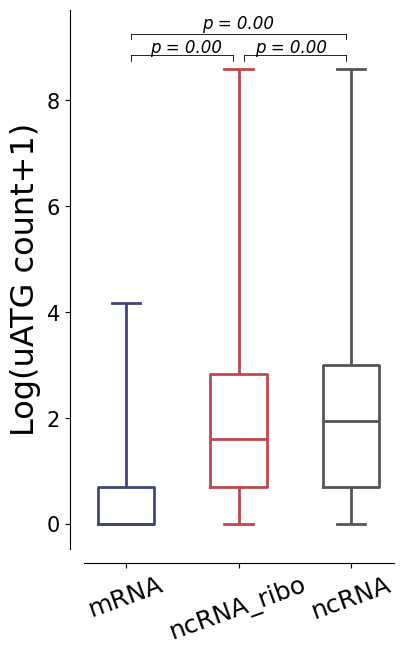

In [19]:
mRNA_uorf_atg = list(np.log(np.array(mRNA_uorf_atg_ori)+1))
ribo_uorf_atg = list(np.log(np.array(ribo_uorf_atg_ori)+1))
ncRNA_uorf_atg = list(np.log(np.array(ncRNA_uorf_atg_ori)+1))

data = pd.DataFrame({'group': ['mRNA'] * len(mRNA_uorf_atg) + ['ncRNA_ribo'] * len(ribo_uorf_atg) + ['ncRNA'] * len(ncRNA_uorf_atg),
                     'energy': mRNA_uorf_atg + ribo_uorf_atg + ncRNA_uorf_atg})

plt.figure(figsize=(4,7))

sns.boxplot(data=data[data['group'] == 'mRNA'], x='group', y='energy', 
            color='#424577', width=0.5, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)
# outliers = get_outliners(data, 'mRNA')

# sns.stripplot(data=outliers, x='group', y='energy', jitter=True, dodge=True, marker='o',
#               color='#424577', edgecolor='black', size=6, alpha=0.5)


sns.boxplot(data=data[data['group'] == 'ncRNA_ribo'], x='group', y='energy', 
            color='#bd484d', width=0.5, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)

sns.boxplot(data=data[data['group'] == 'ncRNA'], x='group', y='energy', fill=False,
            color='#555555', width=0.5, showfliers=False, linewidth=2,
            dodge=False, whis=100)

positions = [0, 1, 2]
ax = plt.gca()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(ticks=positions, labels=['mRNA', 'ncRNA_ribo', 'ncRNA'], fontsize=18, rotation=20)
plt.yticks(fontsize=15)

_, p_value = stats.mannwhitneyu(mRNA_uorf_atg, ribo_uorf_atg)
plt.plot([0.05, 0.95], [8.85,8.85], color='black', lw=0.6);plt.plot([0.05, 0.05], [8.75,8.85], color='black', lw=0.6);plt.plot([0.95, 0.95],  [8.75,8.85], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.33, 0.92), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

_, p_value = stats.mannwhitneyu(ribo_uorf_atg, ncRNA_uorf_atg)
plt.plot([1.05, 1.95], [8.85,8.85], color='black', lw=0.6);plt.plot([1.05, 1.05], [8.75,8.85], color='black', lw=0.6);plt.plot([1.95, 1.95], [8.75,8.85], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.67, 0.92), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

_, p_value = stats.mannwhitneyu(mRNA_uorf_atg, ncRNA_uorf_atg)
plt.plot([0.05, 1.95], [9.25,9.25], color='black', lw=0.6);plt.plot([0.05, 0.05], [9.15,9.25], color='black', lw=0.6);plt.plot([1.95, 1.95], [9.15,9.25], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.5, 0.965), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

plt.xlabel("")
plt.ylabel("Log(uATG count+1)", fontsize=23)
sns.despine()

plt.savefig(f"{path_real}figures/"+'uATG.pdf', dpi=300, format="pdf", bbox_inches='tight')
plt.show()


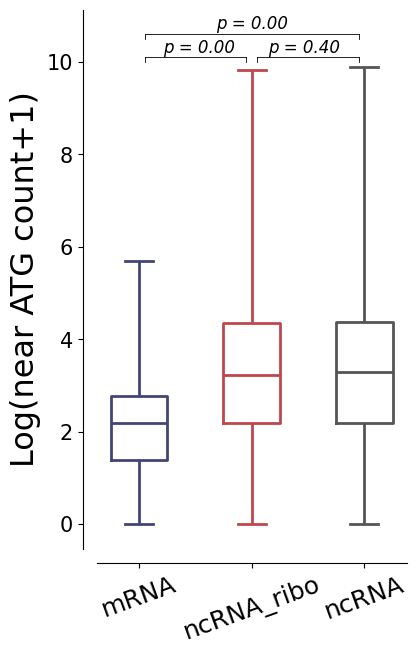

In [20]:
mRNA_uorf_atg = list(np.log(np.array(mRNA_uorf_near_ori)+1))
ribo_uorf_atg = list(np.log(np.array(ribo_uorf_near_ori)+1))
ncRNA_uorf_atg = list(np.log(np.array(ncRNA_uorf_near_ori)+1))

data = pd.DataFrame({'group': ['mRNA'] * len(mRNA_uorf_atg) + ['ncRNA_ribo'] * len(ribo_uorf_atg) + ['ncRNA'] * len(ncRNA_uorf_atg),
                     'energy': mRNA_uorf_atg + ribo_uorf_atg + ncRNA_uorf_atg})

plt.figure(figsize=(4, 7))

sns.boxplot(data=data[data['group'] == 'mRNA'], x='group', y='energy', 
            color='#424577', width=0.5, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)
sns.boxplot(data=data[data['group'] == 'ncRNA_ribo'], x='group', y='energy', 
            color='#bd484d', width=0.5, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)

sns.boxplot(data=data[data['group'] == 'ncRNA'], x='group', y='energy', fill=False,
            color='#555555', width=0.5, showfliers=False, linewidth=2,
            dodge=False, whis=100)

positions = [0, 1, 2]
ax = plt.gca()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(ticks=positions, labels=['mRNA', 'ncRNA_ribo', 'ncRNA'], fontsize=18,rotation=20)
plt.yticks(fontsize=15)

_, p_value = stats.mannwhitneyu(mRNA_uorf_atg, ribo_uorf_atg)
plt.plot([0.05, 0.95], [10.1,10.1], color='black', lw=0.6);plt.plot([0.05, 0.05], [10,10.1], color='black', lw=0.6);plt.plot([0.95, 0.95],  [10,10.1], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.33, 0.92), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

_, p_value = stats.mannwhitneyu(ribo_uorf_atg, ncRNA_uorf_atg)
plt.plot([1.05, 1.95], [10.1,10.1], color='black', lw=0.6);plt.plot([1.05, 1.05], [10,10.1], color='black', lw=0.6);plt.plot([1.95, 1.95], [10,10.1], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.67, 0.92), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

_, p_value = stats.mannwhitneyu(mRNA_uorf_atg, ncRNA_uorf_atg)
plt.plot([0.05, 1.95], [10.6,10.6], color='black', lw=0.6);plt.plot([0.05, 0.05], [10.5,10.6], color='black', lw=0.6);plt.plot([1.95, 1.95], [10.5,10.6], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.5, 0.965), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

plt.xlabel("")
plt.ylabel("Log(near ATG count+1)", fontsize=23)
sns.despine()

plt.savefig(f"{path_real}figures/"+'nearATG.pdf', dpi=300, format="pdf", bbox_inches='tight')
plt.show()


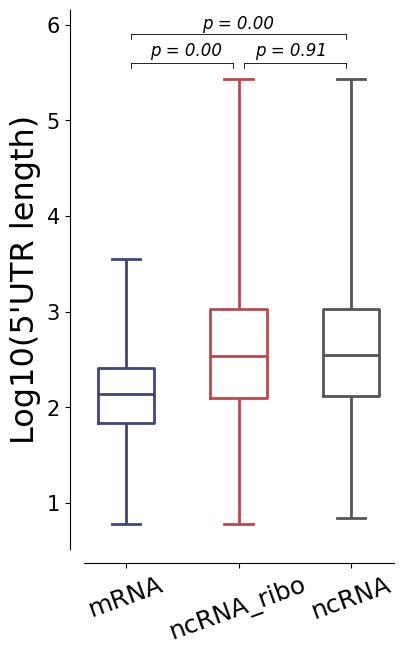

In [21]:
mRNA_utr_len = list(np.log10(np.array(mRNA_utr_len_ori)))
ribo_utr_len = list(np.log10(np.array(ribo_utr_len_ori)))
ncRNA_utr_len = list(np.log10(np.array(ncRNA_utr_len_ori)))
data = pd.DataFrame({'group': ['mRNA'] * len(mRNA_utr_len) + ['ncRNA_ribo'] * len(ribo_utr_len) + ['ncRNA'] * len(ncRNA_utr_len),
                     'energy': mRNA_utr_len + ribo_utr_len + ncRNA_utr_len})

plt.figure(figsize=(4, 7))

sns.boxplot(data=data[data['group'] == 'mRNA'], x='group', y='energy', 
            color='#424577', width=0.5, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)
sns.boxplot(data=data[data['group'] == 'ncRNA_ribo'], x='group', y='energy', 
            color='#bd484d', width=0.5, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)

sns.boxplot(data=data[data['group'] == 'ncRNA'], x='group', y='energy', fill=False,
            color='#555555', width=0.5, showfliers=False, linewidth=2,
            dodge=False, whis=100)

positions = [0, 1, 2]
ax = plt.gca()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(ticks=positions, labels=['mRNA', 'ncRNA_ribo', 'ncRNA'], fontsize=18,rotation=20)
plt.yticks(fontsize=15)

t_statistic, p_value = stats.ttest_ind(mRNA_utr_len, ribo_utr_len)
plt.plot([0.05, 0.95], [5.6,5.6], color='black', lw=0.6);plt.plot([0.05, 0.05], [5.55,5.6], color='black', lw=0.6);plt.plot([0.95, 0.95], [5.55,5.6], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.33, 0.915), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

t_statistic, p_value = stats.ttest_ind(ribo_utr_len, ncRNA_utr_len)
plt.plot([1.05, 1.95], [5.6,5.6], color='black', lw=0.6);plt.plot([1.05, 1.05], [5.55,5.6], color='black', lw=0.6);plt.plot([1.95, 1.95], [5.55,5.6], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.67, 0.915), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

t_statistic, p_value = stats.ttest_ind(mRNA_utr_len, ncRNA_utr_len)
plt.plot([0.05, 1.95], [5.9,5.9], color='black', lw=0.6);plt.plot([0.05, 0.05], [5.85,5.9], color='black', lw=0.6);plt.plot([1.95, 1.95], [5.85,5.9], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.5, 0.965), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

plt.xlabel("")
plt.ylabel("Log10(5'UTR length)", fontsize=23)
sns.despine()

plt.savefig(f"{path_real}figures/"+'length.pdf', dpi=300, format="pdf", bbox_inches='tight')
plt.show()


## uORF

In [22]:
def get_uorf_cnt(utr_seq, near = False):
    starts = set(['ATG'])
    if near:
        starts.add('GTG');starts.add('TTG');starts.add('CTG')
    cnt = 0
    for utr in [utr_seq, utr_seq[1:], utr_seq[2:]]:
        aa = ""
        for i in range(0,len(utr)-2,3):
            codon = utr[i:i+3]
            if codon in starts and aa == "":
                aa = codons_table[codon]
                continue
            if aa != "":
                if codon in stops:
                    cnt += 1
                    aa = ""
                else:
                    aa += codons_table[codon]
        if aa != "":
            cnt += 1
    return cnt

os.chdir('/home/chensa/gb_data/data_for_analysis/')
records = SeqIO.parse("mRNA_5utr_d1.fasta", "fasta")
mRNA_uorf_atg_ori = []; mRNA_uorf_near_ori = []; mRNA_utr_len_ori = []
for rec in records:
    seq = str(rec.seq)[:-4]
    mRNA_uorf_atg_ori.append(get_uorf_cnt(seq))
    mRNA_uorf_near_ori.append(get_uorf_cnt(seq, True))
    mRNA_utr_len_ori.append(len(seq))
records = SeqIO.parse("ribo_5utr_d1.fasta", "fasta")
ribo_uorf_atg_ori = []; ribo_uorf_near_ori = []; ribo_utr_len_ori = []
for rec in records:
    seq = str(rec.seq)[:-4]
    ribo_uorf_atg_ori.append(get_uorf_cnt(seq))
    ribo_uorf_near_ori.append(get_uorf_cnt(seq, True))
    ribo_utr_len_ori.append(len(seq))
records = SeqIO.parse("ncRNA_5utr_d1.fasta", "fasta")
ncRNA_uorf_atg_ori = []; ncRNA_uorf_near_ori = []; ncRNA_utr_len_ori = []
for rec in records:
    seq = str(rec.seq)[:-4]
    ncRNA_uorf_atg_ori.append(get_uorf_cnt(seq))
    ncRNA_uorf_near_ori.append(get_uorf_cnt(seq, True))
    ncRNA_utr_len_ori.append(len(seq))

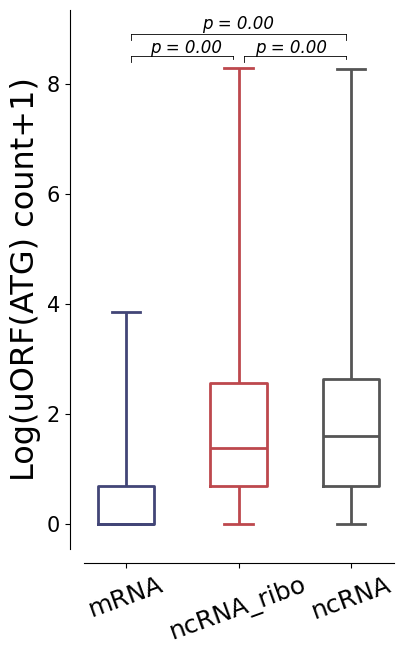

In [23]:
from scipy import stats
mRNA_uorf_atg = list(np.log(np.array(mRNA_uorf_atg_ori)+1))
ribo_uorf_atg = list(np.log(np.array(ribo_uorf_atg_ori)+1))
ncRNA_uorf_atg = list(np.log(np.array(ncRNA_uorf_atg_ori)+1))

data = pd.DataFrame({'group': ['mRNA'] * len(mRNA_uorf_atg) + ['ncRNA_ribo'] * len(ribo_uorf_atg) + ['ncRNA'] * len(ncRNA_uorf_atg),
                     'energy': mRNA_uorf_atg + ribo_uorf_atg + ncRNA_uorf_atg})

plt.figure(figsize=(4,7))

sns.boxplot(data=data[data['group'] == 'mRNA'], x='group', y='energy', 
            color='#424577', width=0.5, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)
# outliers = get_outliners(data, 'mRNA')

# sns.stripplot(data=outliers, x='group', y='energy', jitter=True, dodge=True, marker='o',
#               color='#424577', edgecolor='black', size=6, alpha=0.5)


sns.boxplot(data=data[data['group'] == 'ncRNA_ribo'], x='group', y='energy', 
            color='#bd484d', width=0.5, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)

sns.boxplot(data=data[data['group'] == 'ncRNA'], x='group', y='energy', fill=False,
            color='#555555', width=0.5, showfliers=False, linewidth=2,
            dodge=False, whis=100)

positions = [0, 1, 2]
ax = plt.gca()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(ticks=positions, labels=['mRNA', 'ncRNA_ribo', 'ncRNA'], fontsize=18, rotation=20)
plt.yticks(fontsize=15)

_, p_value = stats.mannwhitneyu(mRNA_uorf_atg, ribo_uorf_atg)
plt.plot([0.05, 0.95], [8.5,8.5], color='black', lw=0.6);plt.plot([0.05, 0.05], [8.4,8.5], color='black', lw=0.6);plt.plot([0.95, 0.95],  [8.45,8.5], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.33, 0.92), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

_, p_value = stats.mannwhitneyu(ribo_uorf_atg, ncRNA_uorf_atg)
plt.plot([1.05, 1.95], [8.5,8.5], color='black', lw=0.6);plt.plot([1.05, 1.05], [8.4,8.5], color='black', lw=0.6);plt.plot([1.95, 1.95], [8.45,8.5], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.67, 0.92), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

_, p_value = stats.mannwhitneyu(mRNA_uorf_atg, ncRNA_uorf_atg)
plt.plot([0.05, 1.95], [8.9,8.9], color='black', lw=0.6);plt.plot([0.05, 0.05], [8.8,8.9], color='black', lw=0.6);plt.plot([1.95, 1.95], [8.8,8.9], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.5, 0.965), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

plt.xlabel("")
plt.ylabel("Log(uORF(ATG) count+1)", fontsize=23)
sns.despine()

plt.savefig(f"{path_real}figures/"+'uORF.pdf', dpi=300, format="pdf", bbox_inches='tight')
plt.show()


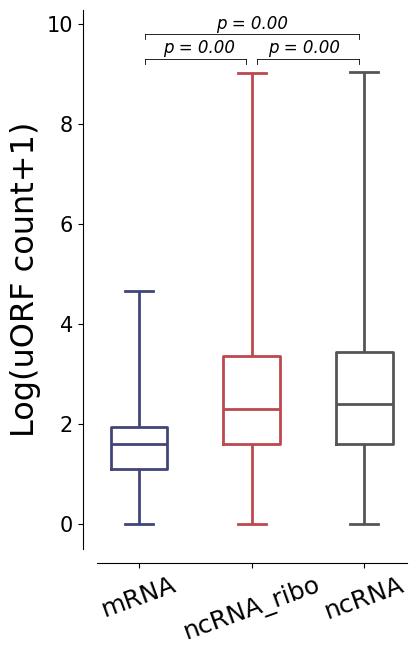

In [25]:
mRNA_uorf_atg = list(np.log(np.array(mRNA_uorf_near_ori)+1))
ribo_uorf_atg = list(np.log(np.array(ribo_uorf_near_ori)+1))
ncRNA_uorf_atg = list(np.log(np.array(ncRNA_uorf_near_ori)+1))
# mRNA_uorf_atg = list(np.array(mRNA_uorf_near_ori))
# ribo_uorf_atg = list(np.array(ribo_uorf_near_ori))
# ncRNA_uorf_atg = list(np.array(ncRNA_uorf_near_ori))

data = pd.DataFrame({'group': ['mRNA'] * len(mRNA_uorf_atg) + ['ncRNA_ribo'] * len(ribo_uorf_atg) + ['ncRNA'] * len(ncRNA_uorf_atg),
                     'energy': mRNA_uorf_atg + ribo_uorf_atg + ncRNA_uorf_atg})

plt.figure(figsize=(4, 7))

sns.boxplot(data=data[data['group'] == 'mRNA'], x='group', y='energy', 
            color='#424577', width=0.5, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)
sns.boxplot(data=data[data['group'] == 'ncRNA_ribo'], x='group', y='energy', 
            color='#bd484d', width=0.5, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)

sns.boxplot(data=data[data['group'] == 'ncRNA'], x='group', y='energy', fill=False,
            color='#555555', width=0.5, showfliers=False, linewidth=2,
            dodge=False, whis=100)

positions = [0, 1, 2]
ax = plt.gca()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(ticks=positions, labels=['mRNA', 'ncRNA_ribo', 'ncRNA'], fontsize=18,rotation=20)
plt.yticks(fontsize=15)

_, p_value = stats.mannwhitneyu(mRNA_uorf_atg, ribo_uorf_atg)
plt.plot([0.05, 0.95], [9.3,9.3], color='black', lw=0.6);plt.plot([0.05, 0.05], [9.2,9.3], color='black', lw=0.6);plt.plot([0.95, 0.95],  [9.2,9.3], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.33, 0.92), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

_, p_value = stats.mannwhitneyu(ribo_uorf_atg, ncRNA_uorf_atg)
plt.plot([1.05, 1.95], [9.3,9.3], color='black', lw=0.6);plt.plot([1.05, 1.05], [9.2,9.3], color='black', lw=0.6);plt.plot([1.95, 1.95], [9.2,9.3], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.67, 0.92), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

_, p_value = stats.mannwhitneyu(mRNA_uorf_atg, ncRNA_uorf_atg)
plt.plot([0.05, 1.95], [9.8,9.8], color='black', lw=0.6);plt.plot([0.05, 0.05], [9.7,9.8], color='black', lw=0.6);plt.plot([1.95, 1.95], [9.7,9.8], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.5, 0.965), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

plt.xlabel("")
plt.ylabel("Log(uORF count+1)", fontsize=23)
sns.despine()

plt.savefig(f"{path_real}figures/"+'nearORF.pdf', dpi=300, format="pdf", bbox_inches='tight')
plt.show()


In [63]:
ncRNA_uorf_near_ori = np.array(ncRNA_uorf_near_ori);mRNA_uorf_near_ori = np.array(mRNA_uorf_near_ori);ribo_uorf_near_ori = np.array(ribo_uorf_near_ori)
v = np.quantile(mRNA_uorf_near_ori,0.75)
v,(np.sum(ncRNA_uorf_near_ori <= v) / len(ncRNA_uorf_near_ori)), (np.sum(ribo_uorf_near_ori <= v) / len(ribo_uorf_near_ori))


(6.0, 0.3710292249047014, 0.4185196950444727)

In [140]:
records = SeqIO.parse("ribo_5utr_d1.fasta", "fasta")
for rec in records:
    seq = str(rec.seq)[:-4]
    if len(seq)>100000:
        print(rec.id)

SPENT001628_163420
SPENT002329_154445
SPENT002482_136255
SPENT002482_114875
SPENT002812_272888
SPENT002812_172730
SPENT002812_248701
SPENT006798_167708


In [161]:
stops

{'TAA', 'TAG', 'TGA'}

## Last uORF distance

In [26]:
def get_uorf_cnt(utr_seq, near = False):
    starts = set(['ATG'])
    if near:
        starts.add('GTG');starts.add('TTG');starts.add('CTG')
    position = -1
    for idx,utr in enumerate([utr_seq, utr_seq[1:], utr_seq[2:]]):
        aa = ""
        for i in range(0,len(utr)-2,3):
            codon = utr[i:i+3]
            if codon in starts and aa == "":
                aa = codons_table[codon]
                continue
            if aa != "":
                if codon in stops:
                    position = max(i+2+idx, position)
                    aa = ""
                else:
                    aa += codons_table[codon]

    return position

os.chdir('/home/chensa/gb_data/data_for_analysis/')
records = SeqIO.parse("mRNA_5utr_d1.fasta", "fasta")
mRNA_uorf_atg_ori = []; mRNA_uorf_near_ori = []
for rec in records:
    seq = str(rec.seq)[:-4]
    position = get_uorf_cnt(seq)
    if position > 0:
        mRNA_uorf_atg_ori.append(len(seq)-position)
    position = get_uorf_cnt(seq, True)
    if position > 0:
        mRNA_uorf_near_ori.append(len(seq)-position)

records = SeqIO.parse("ribo_5utr_d1.fasta", "fasta")
ribo_uorf_atg_ori = []; ribo_uorf_near_ori = []
for rec in records:
    seq = str(rec.seq)[:-4]
    position = get_uorf_cnt(seq)
    if position > 0:
        ribo_uorf_atg_ori.append(len(seq)-position)
    position = get_uorf_cnt(seq, True)
    if position > 0:
        ribo_uorf_near_ori.append(len(seq)-position)
records = SeqIO.parse("ncRNA_5utr_d1.fasta", "fasta")
ncRNA_uorf_atg_ori = []; ncRNA_uorf_near_ori = []
for rec in records:
    seq = str(rec.seq)[:-4]
    position = get_uorf_cnt(seq)
    if position > 0:
        ncRNA_uorf_atg_ori.append(len(seq)-position)
    position = get_uorf_cnt(seq, True)
    if position > 0:
        ncRNA_uorf_near_ori.append(len(seq)-position)

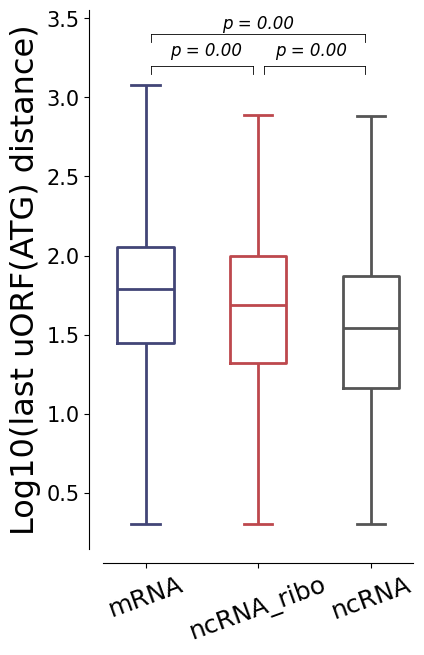

In [27]:
mRNA_uorf_atg = list(np.log10(np.array(mRNA_uorf_atg_ori)+1))
ribo_uorf_atg = list(np.log10(np.array(ribo_uorf_atg_ori)+1))
ncRNA_uorf_atg = list(np.log10(np.array(ncRNA_uorf_atg_ori)+1))

data = pd.DataFrame({'group': ['mRNA'] * len(mRNA_uorf_atg) + ['ncRNA_ribo'] * len(ribo_uorf_atg) + ['ncRNA'] * len(ncRNA_uorf_atg),
                     'energy': mRNA_uorf_atg + ribo_uorf_atg + ncRNA_uorf_atg})

plt.figure(figsize=(4,7))

sns.boxplot(data=data[data['group'] == 'mRNA'], x='group', y='energy', 
            color='#424577', width=0.5, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)

sns.boxplot(data=data[data['group'] == 'ncRNA_ribo'], x='group', y='energy', 
            color='#bd484d', width=0.5, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)

sns.boxplot(data=data[data['group'] == 'ncRNA'], x='group', y='energy', fill=False,
            color='#555555', width=0.5, showfliers=False, linewidth=2,
            dodge=False, whis=100)

positions = [0, 1, 2]
ax = plt.gca()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(ticks=positions, labels=['mRNA', 'ncRNA_ribo', 'ncRNA'], fontsize=18, rotation=20)
plt.yticks(fontsize=15)

t_statistic, p_value = stats.ttest_ind(mRNA_uorf_atg, ribo_uorf_atg)
plt.plot([0.05, 0.95], [3.2,3.2], color='black', lw=0.6);plt.plot([0.05, 0.05], [3.15,3.2], color='black', lw=0.6);plt.plot([0.95, 0.95],  [3.15,3.2], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.33, 0.915), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

t_statistic, p_value = stats.ttest_ind(ribo_uorf_atg, ncRNA_uorf_atg)
plt.plot([1.05, 1.95], [3.2,3.2], color='black', lw=0.6);plt.plot([1.05, 1.05], [3.15,3.2], color='black', lw=0.6);plt.plot([1.95, 1.95], [3.15,3.2], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.67, 0.915), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

t_statistic, p_value = stats.ttest_ind(mRNA_uorf_atg, ncRNA_uorf_atg)
plt.plot([0.05, 1.95], [3.4,3.4], color='black', lw=0.6);plt.plot([0.05, 0.05], [3.35,3.4], color='black', lw=0.6);plt.plot([1.95, 1.95], [3.35,3.4], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.5, 0.965), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

plt.xlabel("")
plt.ylabel("Log10(last uORF(ATG) distance)", fontsize=23)
sns.despine()

plt.savefig(f"{path_real}figures/"+'uORF_distance.pdf', dpi=300, format="pdf", bbox_inches='tight')
plt.show()


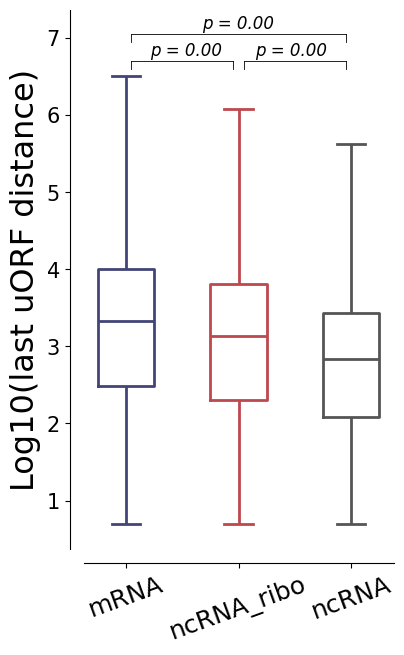

In [28]:
mRNA_uorf_atg = list(np.log(np.array(mRNA_uorf_near_ori)+1))
ribo_uorf_atg = list(np.log(np.array(ribo_uorf_near_ori)+1))
ncRNA_uorf_atg = list(np.log(np.array(ncRNA_uorf_near_ori)+1))

data = pd.DataFrame({'group': ['mRNA'] * len(mRNA_uorf_atg) + ['ncRNA_ribo'] * len(ribo_uorf_atg) + ['ncRNA'] * len(ncRNA_uorf_atg),
                     'energy': mRNA_uorf_atg + ribo_uorf_atg + ncRNA_uorf_atg})

plt.figure(figsize=(4, 7))

sns.boxplot(data=data[data['group'] == 'mRNA'], x='group', y='energy', 
            color='#424577', width=0.5, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)
sns.boxplot(data=data[data['group'] == 'ncRNA_ribo'], x='group', y='energy', 
            color='#bd484d', width=0.5, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)

sns.boxplot(data=data[data['group'] == 'ncRNA'], x='group', y='energy', fill=False,
            color='#555555', width=0.5, showfliers=False, linewidth=2,
            dodge=False, whis=100)

positions = [0, 1, 2]
ax = plt.gca()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(ticks=positions, labels=['mRNA', 'ncRNA_ribo', 'ncRNA'], fontsize=18,rotation=20)
plt.yticks(fontsize=15)

t_statistic, p_value = stats.ttest_ind(mRNA_uorf_atg, ribo_uorf_atg)
plt.plot([0.05, 0.95], [6.7,6.7], color='black', lw=0.6);plt.plot([0.05, 0.05], [6.6,6.7], color='black', lw=0.6);plt.plot([0.95, 0.95],  [6.6,6.7], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.33, 0.915), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

t_statistic, p_value = stats.ttest_ind(ribo_uorf_atg, ncRNA_uorf_atg)
plt.plot([1.05, 1.95], [6.7,6.7], color='black', lw=0.6);plt.plot([1.05, 1.05], [6.6,6.7], color='black', lw=0.6);plt.plot([1.95, 1.95], [6.6,6.7], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.67, 0.915), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

t_statistic, p_value = stats.ttest_ind(mRNA_uorf_atg, ncRNA_uorf_atg)
plt.plot([0.05, 1.95], [7.05,7.05], color='black', lw=0.6);plt.plot([0.05, 0.05], [6.95,7.05], color='black', lw=0.6);plt.plot([1.95, 1.95], [6.95,7.05], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.5, 0.965), xycoords='axes fraction',
             ha='center', fontsize=12, style='italic')

plt.xlabel("")
plt.ylabel("Log10(last uORF distance)", fontsize=23)
sns.despine()

plt.savefig(f"{path_real}figures/"+'nearORF_distance.pdf', dpi=300, format="pdf", bbox_inches='tight')
plt.show()


## pair kozak distances

In [266]:
def get_uorf_cnt(utr_seq, near = False):
    starts = set(['ATG'])
    if near:
        starts.add('GTG');starts.add('TTG');starts.add('CTG')
    position = -1
    for idx,utr in enumerate([utr_seq, utr_seq[1:], utr_seq[2:]]):
        aa = ""
        for i in range(0,len(utr)-2,3):
            codon = utr[i:i+3]
            if codon in starts and aa == "":
                position = max(i+idx, position)
                aa = codons_table[codon]
                continue
            if aa != "":
                if codon in stops:
                    aa = ""
                else:
                    aa += codons_table[codon]
    if position > 6:
        dist = get_dist(utr_seq[position-6:position+4])
        return dist
    else:
        return -1
    
os.chdir('/home/chensa/gb_data/data_for_analysis/')
records = SeqIO.parse("mRNA_5utr_d1.fasta", "fasta")
mRNA_uorf_atg_ori = []; mRNA_uorf_near_ori = []
for rec in records:
    seq = str(rec.seq)[:-4]
    position = get_uorf_cnt(seq)
    if position > 0:
        mRNA_uorf_atg_ori.append(get_dist(str(rec.seq)[-10:])-position)
    position = get_uorf_cnt(seq, True)
    if position > 0:
        mRNA_uorf_near_ori.append(get_dist(str(rec.seq)[-10:])-position)

records = SeqIO.parse("ribo_5utr_d1.fasta", "fasta")
ribo_uorf_atg_ori = []; ribo_uorf_near_ori = []
for rec in records:
    seq = str(rec.seq)[:-4]
    position = get_uorf_cnt(seq)
    if position > 0:
        ribo_uorf_atg_ori.append(get_dist(str(rec.seq)[-10:])-position)
    position = get_uorf_cnt(seq, True)
    if position > 0:
        ribo_uorf_near_ori.append(get_dist(str(rec.seq)[-10:])-position)
records = SeqIO.parse("ncRNA_5utr_d1.fasta", "fasta")
ncRNA_uorf_atg_ori = []; ncRNA_uorf_near_ori = []
for rec in records:
    seq = str(rec.seq)[:-4]
    position = get_uorf_cnt(seq)
    if position > 0:
        ncRNA_uorf_atg_ori.append(get_dist(str(rec.seq)[-10:])-position)
    position = get_uorf_cnt(seq, True)
    if position > 0:
        ncRNA_uorf_near_ori.append(get_dist(str(rec.seq)[-10:])-position)

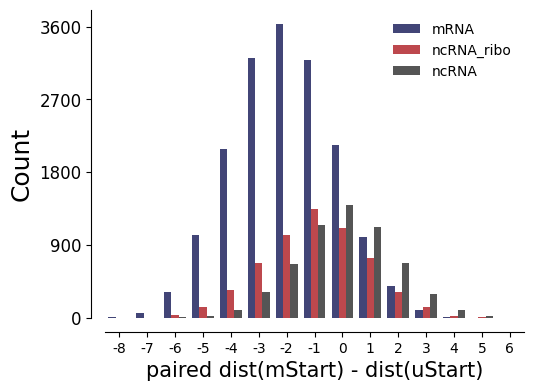

In [269]:
fig,ax = plt.subplots(figsize=(5.4,4))

dict_keys = list(np.arange(-8,7,1))
# bins_mRNA = np.log(np.array([mRNA_uorf_near_ori.count(i) for i in dict_keys])+1)
# bins_ribo = np.log(np.array([ribo_uorf_near_ori.count(i) for i in dict_keys])+1)
# bins_ncRNA = np.log(np.array([ncRNA_uorf_near_ori.count(i) for i in dict_keys])+1)
bins_mRNA = [mRNA_uorf_near_ori.count(i) for i in dict_keys]
bins_ribo = [ribo_uorf_near_ori.count(i) for i in dict_keys]
bins_ncRNA = [ncRNA_uorf_near_ori.count(i) for i in dict_keys]

ax.bar(np.arange(-8,7,1)-0.26, bins_mRNA, width=0.26, color='#424577', label='mRNA')
ax.bar(np.arange(-8,7,1), bins_ribo, width=0.26, color='#bd484d', label='ncRNA_ribo')
ax.bar(np.arange(-8,7,1)+0.26, bins_ncRNA, width=0.26, color='#555555', label='ncRNA')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.set_xlim(-8.5, 6.5)
_ = ax.set_xticks(np.arange(-8,7,1))
_ = ax.set_xticklabels(np.arange(-8,7,1), fontsize=10)
_ = ax.set_yticks(np.arange(0, 3700, 900))
_ = ax.set_yticklabels(np.arange(0, 3700, 900), fontsize=12)
ax.set_xlabel("paired dist(mStart) - dist(uStart)", fontsize=15)
ax.set_ylabel("Count", fontsize=18)
plt.legend(fontsize=10, frameon=False)
plt.savefig(f"{path_real}figures/"+'Pair_distance_hist.pdf', dpi=300, format="pdf", bbox_inches='tight')

In [210]:
# import warnings
# warnings.filterwarnings("ignore")
# fig,ax = plt.subplots(figsize=(4.5,2))
# sns.distplot(mRNA_uorf_atg_ori, hist=False, kde_kws={"color": "#424577", "lw": 2, }, label='mRNA')
# sns.distplot(ribo_uorf_atg_ori, hist=False, kde_kws={"color": "#bd484d", "lw": 2, }, label='ncRNA_ribo')
# sns.distplot(ncRNA_uorf_atg_ori, hist=False, kde_kws={"color": "#555555", "lw": 2, }, label='ncRNA')
# plt.grid(False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(True)
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_position(('outward', 10))
# ax.spines['bottom'].set_position(('outward', 10))
# plt.legend(loc='upper right', fontsize=10, bbox_to_anchor=(0.4, 1), frameon=False)
# ax.set_ylabel("Density", fontsize=15)
# # ax.set_yticks(np.arange(0, 2.1, 0.5))
# # ax.set_yticklabels(np.arange(0, 2.1, 0.5), fontsize=12)
# # ax.set_xticks(np.arange(0.2, 1.5, 0.2))
# # ax.set_xticklabels([0.2,0.4,0.6,0.8,1.0,1.2,1.4], fontsize=12)
# ax.set_xlabel("Fickett score", fontsize=15)
# plt.savefig(f"{path_real}figures/"+'Pair_distance.pdf', dpi=300, format="pdf", bbox_inches='tight')

In [254]:
dict(Counter(mRNA_uorf_near_ori)).keys(), dict(Counter(ribo_uorf_near_ori)).keys(), dict(Counter(ncRNA_uorf_near_ori)).keys(),Counter(mRNA_uorf_near_ori), np.log(7)

(dict_keys([-5, -2, -4, -3, 0, 2, -1, -6, 1, -7, 3, -8, 4, 5]),
 dict_keys([0, 1, -2, -3, 2, -1, -5, -6, -4, 3, 4, -7, 5, 6]),
 dict_keys([1, 2, -1, -3, 0, -2, -5, 3, -4, 4, -6, 5, 6]),
 Counter({-2: 3626,
          -3: 3206,
          -1: 3191,
          0: 2140,
          -4: 2092,
          -5: 1028,
          1: 1002,
          2: 399,
          -6: 320,
          3: 99,
          -7: 54,
          4: 16,
          -8: 6,
          5: 2}),
 1.9459101490553132)

In [256]:
bins_mRNA

array([1.94591015, 4.00733319, 5.77144112, 6.93634274, 7.64635372,
       8.0730912 , 8.19616114, 8.06840296, 7.66902829, 6.91075079,
       5.99146455, 4.60517019, 2.83321334, 1.09861229, 0.        ])

## Codon usage bias

In [32]:
from cpmodule import fickett
from cpmodule import FrameKmer
coding = {}
noncoding = {}
hexamer_dat = "Human_Hexamer.tsv"
for line in open(hexamer_dat, 'r'):
    line = line.strip()
    fields = line.split()
    if fields[0] == 'hexamer':
        continue
    coding[fields[0]] = float(fields[1])
    noncoding[fields[0]] = float(fields[2])

In [33]:
os.chdir('/home/chensa/gb_data/data_for_analysis/')
mrna_fickett = []; ribo_fickett = []; ncRNA_fickett = []
mrna_hexamer = []; ribo_hexamer = []; ncRNA_hexamer = []
records = SeqIO.parse("mRNA_orf.fasta", "fasta")
for rec in records:
    seq = str(rec.seq)
    mrna_fickett.append(fickett.fickett_value(seq))
    mrna_hexamer.append(FrameKmer.kmer_ratio(seq, 6, 3, coding, noncoding))
records = SeqIO.parse("ribo_orf.fasta", "fasta")
for rec in records:
    seq = str(rec.seq)
    ribo_fickett.append(fickett.fickett_value(seq))
    ribo_hexamer.append(FrameKmer.kmer_ratio(seq, 6, 3, coding, noncoding))
records = SeqIO.parse("ncRNA_orf.fasta", "fasta")
for rec in records:
    seq = str(rec.seq)
    ncRNA_fickett.append(fickett.fickett_value(seq))
    ncRNA_hexamer.append(FrameKmer.kmer_ratio(seq, 6, 3, coding, noncoding))

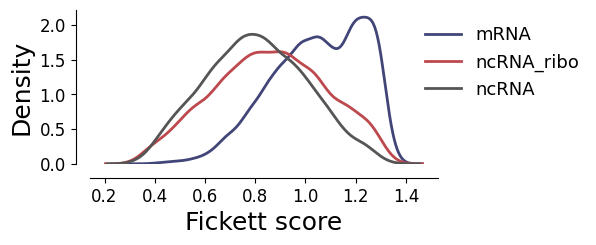

In [281]:
import warnings
warnings.filterwarnings("ignore")
fig,ax = plt.subplots(figsize=(4.5,2))
sns.distplot(mrna_fickett, hist=False, kde_kws={"color": "#424577", "lw": 2, }, label='mRNA')
sns.distplot(ribo_fickett, hist=False, kde_kws={"color": "#bd484d", "lw": 2, }, label='ncRNA_ribo')
sns.distplot(ncRNA_fickett, hist=False, kde_kws={"color": "#555555", "lw": 2, }, label='ncRNA')
plt.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.legend(loc='upper right', fontsize=13, bbox_to_anchor=(1.45, 1), frameon=False)
ax.set_ylabel("Density", fontsize=18)
ax.set_yticks(np.arange(0, 2.1, 0.5))
ax.set_yticklabels(np.arange(0, 2.1, 0.5), fontsize=12)
ax.set_xticks(np.arange(0.2, 1.5, 0.2))
ax.set_xticklabels([0.2,0.4,0.6,0.8,1.0,1.2,1.4], fontsize=12)
ax.set_xlabel("Fickett score", fontsize=18)
plt.savefig(f"{path_real}figures/"+'fickett.pdf', dpi=300, format="pdf", bbox_inches='tight')

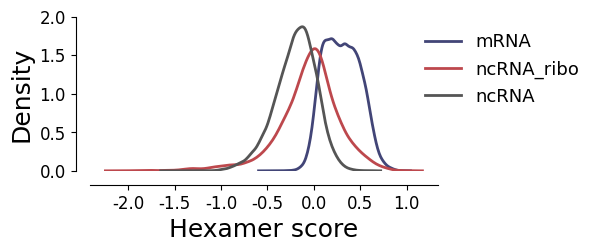

In [280]:
import warnings
warnings.filterwarnings("ignore")
fig,ax = plt.subplots(figsize=(4.5,2))
sns.distplot(mrna_hexamer, hist=False, kde_kws={"color": "#424577", "lw": 2, }, label='mRNA')
sns.distplot(ribo_hexamer, hist=False, kde_kws={"color": "#bd484d", "lw": 2, }, label='ncRNA_ribo')
sns.distplot(ncRNA_hexamer, hist=False, kde_kws={"color": "#555555", "lw": 2, }, label='ncRNA')
plt.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.legend(loc='upper right', fontsize=13, bbox_to_anchor=(1.45, 1), frameon=False)
ax.set_ylabel("Density", fontsize=18)
ax.set_yticks(np.arange(0, 2.1, 0.5))
ax.set_yticklabels(np.arange(0, 2.1, 0.5), fontsize=12)
ax.set_xticks(np.arange(-2, 1.1, 0.5))
ax.set_xticklabels(np.arange(-2, 1.1, 0.5), fontsize=12)
ax.set_xlabel("Hexamer score", fontsize=18)
plt.savefig(f"{path_real}figures/"+'hexamer.pdf', dpi=300, format="pdf", bbox_inches='tight')

In [54]:
ncRNA_fickett = np.array(ncRNA_fickett);mrna_fickett = np.array(mrna_fickett);ribo_fickett = np.array(ribo_fickett)
v = np.quantile(mrna_fickett,0.25)
v,(np.sum(ncRNA_fickett >= v) / len(ncRNA_fickett)), (np.sum(ribo_fickett >= v) / len(ribo_fickett))


(0.92005, 0.2947903430749682, 0.4024777636594663)

In [55]:
ncRNA_hexamer = np.array(ncRNA_hexamer);mrna_hexamer = np.array(mrna_hexamer);ribo_hexamer = np.array(ribo_hexamer)
v = np.quantile(mrna_hexamer,0.25)
v,(np.sum(ncRNA_hexamer >= v) / len(ncRNA_hexamer)), (np.sum(ribo_hexamer >= v) / len(ribo_hexamer))


(0.14708153745054758, 0.04304320203303685, 0.23904066073697586)